In [1]:
#importing the simulation, filterer, controller and agent classes
import sys
sys.path.append('../')
from humancompatible.interconnect.simulators.simulation import Simulation
from humancompatible.interconnect.simulators.filterers.base_filterer import Filterer
from humancompatible.interconnect.simulators.controllers.base_controller import Controller
from humancompatible.interconnect.simulators.agents.base_agent import Agent
from humancompatible.interconnect.simulators.aggregators.base_aggregator import Aggregator
from humancompatible.interconnect.simulators.reference import ReferenceSignal
from humancompatible.interconnect.simulators.delay import Delay
from humancompatible.interconnect.simulators.population import Population

In [2]:
refSig = ReferenceSignal(name="r")
refSig.set_reference_signal(0.5)

In [3]:
agg1 = Aggregator(name="+")
agg2 = Aggregator(name="+")

In [4]:
cont = Controller(name="C")

In [5]:
from math import exp

def transition_map1(state):
    return state * 0.9

def transition_map2(state):
    return state * 1.1

def output_map1(state):
    return state + 1

def output_map2(state):
    return state - 1

def probability_function1(signal):
    return exp(signal) / (exp(signal) + 1)

def probability_function2(signal):
    return 1 / (exp(signal) + 1)

initial_state = 0

transition_maps = [transition_map1, transition_map2]
output_maps = [output_map1, output_map2]

probability_functions = {
    'transition': [probability_function1, probability_function2],
    'output': [probability_function1, probability_function2]
}

pop = Population(name="P")
for i in range(3):
    pop.add_agent(Agent(initial_state, transition_maps, output_maps, probability_functions))

In [6]:
delay = Delay(name="Z", time=1)

In [7]:
fil = Filterer(name="F")

In [8]:
sim = Simulation()

In [9]:
sim.system.add_nodes([refSig, agg1, cont,pop, agg2, delay, fil])
sim.system.connect_nodes(refSig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop)
sim.system.connect_nodes(pop, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refSig)
sim.system.set_checkpoint_node(agg1)

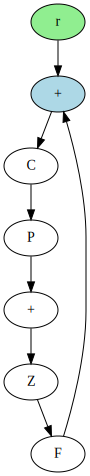

In [10]:
sim.system.render_graph()

In [15]:
validSystem = sim.system.check_system()
if validSystem:
    print("System is valid")
else:
    for e in validSystem:
        print(e)

System Validity Check:
True


In [16]:
sim.system.run(200, showTrace=False)